In [1]:
# !pip install transformers

In [2]:
import os
import random
import json
import requests
import torch
import torch.nn as nn
from tqdm import tqdm
import zipfile
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2Tokenizer, GPT2Model
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import Counter
from pycocotools.coco import COCO
from torchvision import models

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# ------------------------------------------ DATASET DOWNLOAD STARTED-----------------------------------------------


# Download and preprocess COCO dataset
def download_subset_coco(num_images=5000):
    os.makedirs("coco/images", exist_ok=True)
    os.makedirs("coco/annotations", exist_ok=True)
    annotation_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    print("Downloading annotation file...")
    response = requests.get(annotation_url, stream=True)
    with open("annotations.zip", "wb") as f:
        f.write(response.content)
    with zipfile.ZipFile("annotations.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove("annotations.zip")
    with open("annotations/captions_train2017.json", "r") as f:
        annotations = json.load(f)
    subset_images = annotations["images"][:num_images]
    image_ids = [img["id"] for img in subset_images]
    subset_annotations = [
        ann for ann in annotations["annotations"] if ann["image_id"] in image_ids
    ]
    subset_data = {
        "info": annotations["info"],
        "licenses": annotations["licenses"],
        "images": subset_images,
        "annotations": subset_annotations,
    }
    with open("coco/annotations/captions_subset_train2017.json", "w") as f:
        json.dump(subset_data, f)
    print("Downloading images...")
    for img in tqdm(subset_images):
        img_url = f"http://images.cocodataset.org/train2017/{img['file_name']}"
        img_path = f"coco/images/{img['file_name']}"
        if not os.path.exists(img_path):
            response = requests.get(img_url)
            with open(img_path, "wb") as f:
                f.write(response.content)
    return "coco/images", "coco/annotations/captions_subset_train2017.json"


# For testing the download function independently
if __name__ == "__main__":
    images_dir, annotations_file = download_subset_coco(num_images=10000) #Change here for downloading n number of images...
    print(f"\nDownload complete!")
    print(f"Images directory: {images_dir}")
    print(f"Annotations file: {annotations_file}")


# ------------------------------------------ DATASET DOWNLOAD DONE -----------------------------------------------


Using device: cuda


100%|██████████| 10000/10000 [00:02<00:00, 3706.69it/s]


Download complete!
Images directory: coco/images
Annotations file: coco/annotations/captions_subset_train2017.json


In [3]:

# Dataset class for COCO
class ImageCaptioningDataset(Dataset):
    def __init__(self, root_dir, annotations_file, transform=None, max_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotations_file)
        self.img_ids = list(self.coco.imgs.keys())[:max_samples]
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        
        # Properly initialize the padding token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id


    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
#         caption = anns[0]['caption']  # Use the first caption for simplicity
        
        captions = [ann['caption'] for ann in anns]  # Use all captions
        caption = random.choice(captions)  # Select a random caption for each training sample


        # Tokenize caption using GPT-2 tokenizer
        tokens = self.tokenizer.encode(
            caption,
            add_special_tokens=True,  # Adds <BOS> and <EOS> tokens
            truncation=True,
            max_length=50  # Truncate captions longer than 50 tokens
        )

        return image, torch.tensor(tokens)

    
    def collate_fn(self, batch):
        images, captions = zip(*batch)
        images = torch.stack(images, dim=0)
        
        # Pad captions to the same length
        captions = torch.nn.utils.rnn.pad_sequence(
            captions,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id
        )
        return images, captions


# ------------------------------------------ ENCODER & DECODER STARTED-----------------------------------------------
import torch.nn.functional as F

class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size, encoder_size):
        super(AttentionMechanism, self).__init__()
        self.attention = nn.Linear(hidden_size + encoder_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size = hidden.size(0)
        seq_len = hidden.size(1)  # Sequence length of the decoder hidden states
        src_len = encoder_outputs.size(1)  # Sequence length of the encoder outputs (typically 1)

        # Expand encoder outputs to match the decoder sequence length
        encoder_outputs = encoder_outputs.repeat(1, seq_len, 1)  # [batch_size, seq_len, embed_size]

        # Combine hidden and encoder outputs
        energy = torch.tanh(self.attention(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, seq_len, hidden_size]
        attention = self.v(energy).squeeze(2)  # [batch_size, seq_len]

        # Apply mask (if provided) to ignore padding in encoder outputs
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e9)

        return F.softmax(attention, dim=1)  # [batch_size, seq_len]




class GPT2Encoder(nn.Module):
    def __init__(self, embed_size):
        super(GPT2Encoder, self).__init__()
        # Use CNN features instead of GPT2 for images
        self.cnn = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])
        # Add a linear layer to get the desired embedding size
        self.fc = nn.Linear(2048, embed_size)  # ResNet50 has 2048 features

    def forward(self, images):
        features = self.cnn(images)  # [batch_size, 2048, 1, 1]
        features = features.squeeze(-1).squeeze(-1)  # [batch_size, 2048]
        return self.fc(features)  # [batch_size, embed_size]

    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2, dropout_rate=0.3):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.embed_dropout = nn.Dropout(dropout_rate)
        
        # LSTM with dropout
        self.lstm = nn.LSTM(embed_size + embed_size, hidden_size, num_layers, 
                             batch_first=True, dropout=dropout_rate)
        
        # Attention mechanism
        self.attention = AttentionMechanism(hidden_size, embed_size)
        
        # Linear transformation for context vector
        self.context_to_hidden = nn.Linear(embed_size, hidden_size)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = self.embed_dropout(embeddings)

        # Add sequence length dimension to features for attention
        features = features.unsqueeze(1)  # [batch_size, 1, embed_size]
#         print("Features shape:", features.shape)  # Debug print

        # Repeat features to match caption sequence length
        features_repeated = features.repeat(1, captions.size(1), 1)  # [batch_size, seq_len, embed_size]
#         print("Features repeated shape:", features_repeated.shape)  # Debug print

        # Combine features and embeddings for LSTM input
        inputs = torch.cat((features_repeated, embeddings), dim=2)  # [batch_size, seq_len, embed_size * 2]
        hiddens, _ = self.lstm(inputs)  # Base LSTM output
#         print("Hiddens shape:", hiddens.shape)  # Debug print

        # Apply attention
        attention_weights = self.attention(hiddens, features)  # Attention applied on original features
#         print("Attention weights shape:", attention_weights.shape)  # Debug print

        context_vector = attention_weights.unsqueeze(2) * features  # Context vector computation
        context_vector = context_vector.sum(dim=1)  # Aggregate weighted features

        # Transform context vector to match hidden size
        context_vector = self.context_to_hidden(context_vector)  # [batch_size, hidden_size]

        # Combine LSTM output and transformed context vector
        hiddens = self.layer_norm(hiddens + context_vector.unsqueeze(1))  # Residual connection
        outputs = self.linear(hiddens)  # Final output layer

        return outputs





    
    


# ------------------------------------------ ENCODER & DECODER ENDED -----------------------------------------------


# Hyperparameters and Data Loading
embed_size = 256
hidden_size = 512
batch_size = 32 #16
num_epochs = 80 #170
learning_rate = 1e-4
num_layers = 1
num_samples = 10000 # This loads this many images...


# Enhanced data augmentation for image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flipping
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create dataset and dataloader
dataset = ImageCaptioningDataset(
    root_dir='coco/images',
    annotations_file='coco/annotations/captions_subset_train2017.json',
    transform=transform,
    max_samples=num_samples
)



# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Print sizes to confirm correct splitting
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Create DataLoaders for train and validation sets
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=dataset.collate_fn,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=dataset.collate_fn,
    num_workers=4
)


# Models and Training

# -------------------------------------- STARTING TO CREATE ENCODER INSTANCE ----------------------------------------

gpt2_encoder = GPT2Encoder(embed_size).to(device)

# -------------------------------------------- ENCODER INSTANCE CREATED ---------------------------------------------



# -------------------------------------- STARTING TO CREATE DECODER INSTANCE ----------------------------------------

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print(f"Padding token: {tokenizer.pad_token}, Padding token ID: {tokenizer.pad_token_id}")

decoder = DecoderRNN(embed_size, hidden_size, len(tokenizer), num_layers=num_layers).to(device)
# Resize the embedding layer in the decoder to match the new vocabulary size
decoder.embed = nn.Embedding(len(tokenizer), embed_size).to(device)
print(f"Decoder embedding size: {decoder.embed.num_embeddings}, Tokenizer vocab size: {len(tokenizer)}")

# -------------------------------------------- DECODER INSTANCE CREATED ---------------------------------------------


# criterion = nn.CrossEntropyLoss(ignore_index=dataset.word2idx["<PAD>"])
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)


encoder_optimizer = torch.optim.AdamW(gpt2_encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=learning_rate)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Training samples: 8000, Validation samples: 2000


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Padding token: [PAD], Padding token ID: 50257


/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Decoder embedding size: 50258, Tokenizer vocab size: 50258


In [4]:

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_bleus = []
        self.val_bleus = []

    def update(self, loss, acc, bleu, is_train=True):
        if is_train:
            self.train_losses.append(loss)
            self.train_accuracies.append(acc)
            self.train_bleus.append(bleu)
        else:
            self.val_losses.append(loss)
            self.val_accuracies.append(acc)
            self.val_bleus.append(bleu)

    def plot_metrics(self, save_path=None):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Train Acc")
        plt.plot(self.val_accuracies, label="Val Acc")
        plt.plot(self.train_bleus, label="Train BLEU")
        plt.plot(self.val_bleus, label="Val BLEU")
        plt.xlabel("Epoch")
        plt.ylabel("Metrics")
        plt.legend()

        if save_path:
            plt.savefig(save_path)
        plt.show()


# BLEU Score Calculation

def calculate_bleu_score(predictions, references, tokenizer):
    smoothing_function = SmoothingFunction().method4
    total_bleu_score = 0.0
    batch_size = predictions.size(0)

    for i in range(batch_size):
        predicted_caption = tokenizer.decode(predictions[i].tolist(), skip_special_tokens=True).split()
        reference_caption = tokenizer.decode(references[i].tolist(), skip_special_tokens=True).split()
        bleu_score = sentence_bleu([reference_caption], predicted_caption, smoothing_function=smoothing_function)
        total_bleu_score += bleu_score

    return total_bleu_score / batch_size



# Accuracy Calculation
def calculate_accuracy(outputs, targets):
    _, preds = outputs.max(-1)
    mask = targets != 0
    correct = (preds == targets) & mask
    accuracy = correct.sum().item() / mask.sum().item() * 100
    return accuracy


Starting training...

Epoch [1/80]


Validation Epoch 1: 100%|██████████| 63/63 [00:04<00:00, 13.14it/s, acc=58.44%, bleu=0.0427, loss=3.7424]



Epoch [1/80]: Train Loss: 130.7276, Train Acc: 48.04%, Train BLEU: 0.0248
Epoch [1/80]: Val Loss: 4.1621, Val Acc: 51.96%, Val BLEU: 0.0419

Epoch [2/80]


Validation Epoch 2: 100%|██████████| 63/63 [00:04<00:00, 13.90it/s, acc=54.30%, bleu=0.0524, loss=3.8487]



Epoch [2/80]: Train Loss: 124.5028, Train Acc: 54.47%, Train BLEU: 0.0474
Epoch [2/80]: Val Loss: 3.8049, Val Acc: 56.14%, Val BLEU: 0.0536

Epoch [3/80]


Validation Epoch 3: 100%|██████████| 63/63 [00:04<00:00, 14.42it/s, acc=60.31%, bleu=0.0696, loss=3.3120]



Epoch [3/80]: Train Loss: 119.4028, Train Acc: 56.95%, Train BLEU: 0.0566
Epoch [3/80]: Val Loss: 3.7412, Val Acc: 56.06%, Val BLEU: 0.0619

Epoch [4/80]


Validation Epoch 4: 100%|██████████| 63/63 [00:04<00:00, 14.35it/s, acc=51.39%, bleu=0.0582, loss=3.8910]



Epoch [4/80]: Train Loss: 114.6848, Train Acc: 58.22%, Train BLEU: 0.0636
Epoch [4/80]: Val Loss: 3.6090, Val Acc: 57.94%, Val BLEU: 0.0607

Epoch [5/80]


Validation Epoch 5: 100%|██████████| 63/63 [00:04<00:00, 14.28it/s, acc=58.44%, bleu=0.0394, loss=3.6020]



Epoch [5/80]: Train Loss: 110.2697, Train Acc: 58.32%, Train BLEU: 0.0693
Epoch [5/80]: Val Loss: 3.4856, Val Acc: 59.58%, Val BLEU: 0.0644

Epoch [6/80]


Validation Epoch 6: 100%|██████████| 63/63 [00:04<00:00, 13.90it/s, acc=62.78%, bleu=0.0849, loss=3.1987]



Epoch [6/80]: Train Loss: 105.9727, Train Acc: 59.69%, Train BLEU: 0.0742
Epoch [6/80]: Val Loss: 3.4369, Val Acc: 59.81%, Val BLEU: 0.0711

Epoch [7/80]


Validation Epoch 7: 100%|██████████| 63/63 [00:04<00:00, 14.45it/s, acc=46.15%, bleu=0.0742, loss=3.8432]



Epoch [7/80]: Train Loss: 101.8843, Train Acc: 60.31%, Train BLEU: 0.0778
Epoch [7/80]: Val Loss: 3.4613, Val Acc: 58.59%, Val BLEU: 0.0717

Epoch [8/80]


Validation Epoch 8: 100%|██████████| 63/63 [00:04<00:00, 14.13it/s, acc=62.78%, bleu=0.0920, loss=3.1513]



Epoch [8/80]: Train Loss: 97.9681, Train Acc: 61.41%, Train BLEU: 0.0805
Epoch [8/80]: Val Loss: 3.4426, Val Acc: 58.67%, Val BLEU: 0.0771

Epoch [9/80]


Validation Epoch 9: 100%|██████████| 63/63 [00:04<00:00, 14.35it/s, acc=59.77%, bleu=0.0853, loss=3.1091]



Epoch [9/80]: Train Loss: 94.2579, Train Acc: 61.09%, Train BLEU: 0.0850
Epoch [9/80]: Val Loss: 3.3800, Val Acc: 59.78%, Val BLEU: 0.0742

Epoch [10/80]


Validation Epoch 10: 100%|██████████| 63/63 [00:04<00:00, 13.87it/s, acc=65.94%, bleu=0.0994, loss=3.0891]



Epoch [10/80]: Train Loss: 90.6161, Train Acc: 62.29%, Train BLEU: 0.0871
Epoch [10/80]: Val Loss: 3.3084, Val Acc: 61.15%, Val BLEU: 0.0757

Epoch [11/80]


Validation Epoch 11: 100%|██████████| 63/63 [00:04<00:00, 14.20it/s, acc=60.31%, bleu=0.0649, loss=3.3154]



Epoch [11/80]: Train Loss: 87.1891, Train Acc: 62.12%, Train BLEU: 0.0896
Epoch [11/80]: Val Loss: 3.3714, Val Acc: 60.22%, Val BLEU: 0.0760

Epoch [12/80]


Validation Epoch 12: 100%|██████████| 63/63 [00:04<00:00, 14.14it/s, acc=65.00%, bleu=0.0925, loss=3.0059]



Epoch [12/80]: Train Loss: 83.8598, Train Acc: 62.79%, Train BLEU: 0.0947
Epoch [12/80]: Val Loss: 3.3377, Val Acc: 60.55%, Val BLEU: 0.0815

Epoch [13/80]


Validation Epoch 13: 100%|██████████| 63/63 [00:04<00:00, 14.07it/s, acc=61.25%, bleu=0.0734, loss=3.2780]



Epoch [13/80]: Train Loss: 80.6367, Train Acc: 63.43%, Train BLEU: 0.0964
Epoch [13/80]: Val Loss: 3.2372, Val Acc: 62.57%, Val BLEU: 0.0815

Epoch [14/80]


Validation Epoch 14: 100%|██████████| 63/63 [00:04<00:00, 14.19it/s, acc=65.42%, bleu=0.1379, loss=3.1224]



Epoch [14/80]: Train Loss: 77.5497, Train Acc: 63.58%, Train BLEU: 0.0976
Epoch [14/80]: Val Loss: 3.3078, Val Acc: 60.76%, Val BLEU: 0.0794

Epoch [15/80]


Validation Epoch 15: 100%|██████████| 63/63 [00:04<00:00, 13.73it/s, acc=59.03%, bleu=0.0802, loss=3.3059]



Epoch [15/80]: Train Loss: 74.5705, Train Acc: 63.86%, Train BLEU: 0.1006
Epoch [15/80]: Val Loss: 3.2455, Val Acc: 61.77%, Val BLEU: 0.0818

Epoch [16/80]


Validation Epoch 16: 100%|██████████| 63/63 [00:04<00:00, 14.26it/s, acc=54.81%, bleu=0.1613, loss=3.4068]



Epoch [16/80]: Train Loss: 71.6976, Train Acc: 64.38%, Train BLEU: 0.1020
Epoch [16/80]: Val Loss: 3.2989, Val Acc: 60.41%, Val BLEU: 0.0842

Epoch [17/80]


Validation Epoch 17: 100%|██████████| 63/63 [00:04<00:00, 13.86it/s, acc=61.81%, bleu=0.1159, loss=3.2230]



Epoch [17/80]: Train Loss: 68.9449, Train Acc: 64.25%, Train BLEU: 0.1046
Epoch [17/80]: Val Loss: 3.1232, Val Acc: 64.06%, Val BLEU: 0.0862

Epoch [18/80]


Validation Epoch 18: 100%|██████████| 63/63 [00:04<00:00, 13.89it/s, acc=62.11%, bleu=0.1026, loss=3.1443]



Epoch [18/80]: Train Loss: 66.2576, Train Acc: 64.76%, Train BLEU: 0.1080
Epoch [18/80]: Val Loss: 3.2164, Val Acc: 62.41%, Val BLEU: 0.0838

Epoch [19/80]


Validation Epoch 19: 100%|██████████| 63/63 [00:04<00:00, 13.82it/s, acc=66.25%, bleu=0.1401, loss=3.0647]



Epoch [19/80]: Train Loss: 63.6731, Train Acc: 64.90%, Train BLEU: 0.1087
Epoch [19/80]: Val Loss: 3.1781, Val Acc: 63.56%, Val BLEU: 0.0892

Epoch [20/80]


Validation Epoch 20: 100%|██████████| 63/63 [00:04<00:00, 13.86it/s, acc=64.77%, bleu=0.1029, loss=3.1450]



Epoch [20/80]: Train Loss: 61.1393, Train Acc: 65.76%, Train BLEU: 0.1127
Epoch [20/80]: Val Loss: 3.1722, Val Acc: 63.21%, Val BLEU: 0.0868

Epoch [21/80]


Validation Epoch 21: 100%|██████████| 63/63 [00:04<00:00, 13.89it/s, acc=58.04%, bleu=0.1091, loss=3.3101]



Epoch [21/80]: Train Loss: 58.7215, Train Acc: 65.69%, Train BLEU: 0.1124
Epoch [21/80]: Val Loss: 3.2337, Val Acc: 62.25%, Val BLEU: 0.0862

Epoch [22/80]


Validation Epoch 22: 100%|██████████| 63/63 [00:04<00:00, 14.31it/s, acc=62.89%, bleu=0.1208, loss=3.1098]



Epoch [22/80]: Train Loss: 56.4049, Train Acc: 65.48%, Train BLEU: 0.1143
Epoch [22/80]: Val Loss: 3.2045, Val Acc: 62.66%, Val BLEU: 0.0917

Epoch [23/80]


Validation Epoch 23: 100%|██████████| 63/63 [00:04<00:00, 14.07it/s, acc=57.42%, bleu=0.0940, loss=3.4099]



Epoch [23/80]: Train Loss: 54.1577, Train Acc: 65.81%, Train BLEU: 0.1193
Epoch [23/80]: Val Loss: 3.1786, Val Acc: 62.92%, Val BLEU: 0.0896
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.
Epoch 00023: reducing learning rate of group 0 to 5.0000e-05.

Epoch [24/80]


Validation Epoch 24: 100%|██████████| 63/63 [00:04<00:00, 14.24it/s, acc=64.38%, bleu=0.0642, loss=3.0744]



Epoch [24/80]: Train Loss: 52.4891, Train Acc: 66.73%, Train BLEU: 0.1256
Epoch [24/80]: Val Loss: 3.1676, Val Acc: 63.07%, Val BLEU: 0.0887

Epoch [25/80]


Validation Epoch 25: 100%|██████████| 63/63 [00:04<00:00, 14.21it/s, acc=59.17%, bleu=0.1044, loss=3.6542]



Epoch [25/80]: Train Loss: 51.3775, Train Acc: 67.13%, Train BLEU: 0.1231
Epoch [25/80]: Val Loss: 3.1392, Val Acc: 64.17%, Val BLEU: 0.0947

Epoch [26/80]


Validation Epoch 26: 100%|██████████| 63/63 [00:04<00:00, 13.83it/s, acc=60.16%, bleu=0.1088, loss=3.3120]



Epoch [26/80]: Train Loss: 50.3253, Train Acc: 66.75%, Train BLEU: 0.1283
Epoch [26/80]: Val Loss: 3.1803, Val Acc: 62.91%, Val BLEU: 0.0871

Epoch [27/80]


Validation Epoch 27: 100%|██████████| 63/63 [00:04<00:00, 14.30it/s, acc=57.92%, bleu=0.1185, loss=3.4742]



Epoch [27/80]: Train Loss: 49.2644, Train Acc: 67.07%, Train BLEU: 0.1300
Epoch [27/80]: Val Loss: 3.2211, Val Acc: 61.94%, Val BLEU: 0.0898

Epoch [28/80]


Validation Epoch 28: 100%|██████████| 63/63 [00:04<00:00, 13.99it/s, acc=57.50%, bleu=0.0683, loss=3.2893]



Epoch [28/80]: Train Loss: 48.2264, Train Acc: 67.33%, Train BLEU: 0.1323
Epoch [28/80]: Val Loss: 3.1667, Val Acc: 63.18%, Val BLEU: 0.0902

Epoch [29/80]


Validation Epoch 29: 100%|██████████| 63/63 [00:04<00:00, 13.95it/s, acc=66.88%, bleu=0.1384, loss=2.8960]



Epoch [29/80]: Train Loss: 47.2088, Train Acc: 67.23%, Train BLEU: 0.1340
Epoch [29/80]: Val Loss: 3.1064, Val Acc: 64.25%, Val BLEU: 0.0906

Epoch [30/80]


Validation Epoch 30: 100%|██████████| 63/63 [00:04<00:00, 14.22it/s, acc=62.08%, bleu=0.1200, loss=3.1428]



Epoch [30/80]: Train Loss: 46.1982, Train Acc: 67.11%, Train BLEU: 0.1331
Epoch [30/80]: Val Loss: 3.2207, Val Acc: 62.06%, Val BLEU: 0.0916

Epoch [31/80]


Validation Epoch 31: 100%|██████████| 63/63 [00:04<00:00, 14.05it/s, acc=57.69%, bleu=0.1679, loss=3.3921]



Epoch [31/80]: Train Loss: 45.2062, Train Acc: 67.47%, Train BLEU: 0.1387
Epoch [31/80]: Val Loss: 3.1438, Val Acc: 63.65%, Val BLEU: 0.0900

Epoch [32/80]


Validation Epoch 32: 100%|██████████| 63/63 [00:04<00:00, 14.13it/s, acc=68.18%, bleu=0.1186, loss=2.8349]



Epoch [32/80]: Train Loss: 44.2020, Train Acc: 68.16%, Train BLEU: 0.1401
Epoch [32/80]: Val Loss: 3.1529, Val Acc: 63.20%, Val BLEU: 0.0913

Epoch [33/80]


Validation Epoch 33: 100%|██████████| 63/63 [00:04<00:00, 13.50it/s, acc=67.90%, bleu=0.1057, loss=2.9780]



Epoch [33/80]: Train Loss: 43.2666, Train Acc: 67.69%, Train BLEU: 0.1379
Epoch [33/80]: Val Loss: 3.0982, Val Acc: 64.91%, Val BLEU: 0.0909

Epoch [34/80]


Validation Epoch 34: 100%|██████████| 63/63 [00:04<00:00, 13.92it/s, acc=62.50%, bleu=0.1074, loss=3.0918]



Epoch [34/80]: Train Loss: 42.3116, Train Acc: 68.06%, Train BLEU: 0.1392
Epoch [34/80]: Val Loss: 3.2025, Val Acc: 62.81%, Val BLEU: 0.0944

Epoch [35/80]


Validation Epoch 35: 100%|██████████| 63/63 [00:04<00:00, 14.04it/s, acc=62.50%, bleu=0.0905, loss=3.1859]



Epoch [35/80]: Train Loss: 41.3652, Train Acc: 68.89%, Train BLEU: 0.1420
Epoch [35/80]: Val Loss: 3.1470, Val Acc: 63.45%, Val BLEU: 0.0911

Epoch [36/80]


Validation Epoch 36: 100%|██████████| 63/63 [00:04<00:00, 14.32it/s, acc=71.02%, bleu=0.1050, loss=2.7522]



Epoch [36/80]: Train Loss: 40.4729, Train Acc: 68.42%, Train BLEU: 0.1394
Epoch [36/80]: Val Loss: 3.1987, Val Acc: 62.41%, Val BLEU: 0.0910

Epoch [37/80]


Validation Epoch 37: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s, acc=64.93%, bleu=0.1289, loss=3.1974]



Epoch [37/80]: Train Loss: 39.6007, Train Acc: 68.08%, Train BLEU: 0.1405
Epoch [37/80]: Val Loss: 3.1609, Val Acc: 63.50%, Val BLEU: 0.0924

Epoch [38/80]


Validation Epoch 38: 100%|██████████| 63/63 [00:04<00:00, 14.28it/s, acc=64.38%, bleu=0.0900, loss=3.0085]



Epoch [38/80]: Train Loss: 38.7351, Train Acc: 68.12%, Train BLEU: 0.1468
Epoch [38/80]: Val Loss: 3.1394, Val Acc: 63.45%, Val BLEU: 0.0883

Epoch [39/80]


Validation Epoch 39: 100%|██████████| 63/63 [00:04<00:00, 14.17it/s, acc=51.56%, bleu=0.0665, loss=3.6081]



Epoch [39/80]: Train Loss: 37.8613, Train Acc: 68.89%, Train BLEU: 0.1482
Epoch [39/80]: Val Loss: 3.2118, Val Acc: 62.50%, Val BLEU: 0.0922
Epoch 00039: reducing learning rate of group 0 to 2.5000e-05.
Epoch 00039: reducing learning rate of group 0 to 2.5000e-05.

Epoch [40/80]


Validation Epoch 40: 100%|██████████| 63/63 [00:04<00:00, 14.04it/s, acc=60.55%, bleu=0.1236, loss=3.1717]



Epoch [40/80]: Train Loss: 37.2303, Train Acc: 68.79%, Train BLEU: 0.1516
Epoch [40/80]: Val Loss: 3.2156, Val Acc: 62.24%, Val BLEU: 0.0922

Epoch [41/80]


Validation Epoch 41: 100%|██████████| 63/63 [00:04<00:00, 13.06it/s, acc=66.56%, bleu=0.0941, loss=3.0487]



Epoch [41/80]: Train Loss: 36.8129, Train Acc: 68.88%, Train BLEU: 0.1518
Epoch [41/80]: Val Loss: 3.1578, Val Acc: 63.23%, Val BLEU: 0.0920

Epoch [42/80]


Validation Epoch 42: 100%|██████████| 63/63 [00:04<00:00, 14.35it/s, acc=55.83%, bleu=0.1152, loss=3.7316]



Epoch [42/80]: Train Loss: 36.3624, Train Acc: 69.55%, Train BLEU: 0.1556
Epoch [42/80]: Val Loss: 3.2195, Val Acc: 62.39%, Val BLEU: 0.0930

Epoch [43/80]


Validation Epoch 43: 100%|██████████| 63/63 [00:04<00:00, 14.02it/s, acc=57.14%, bleu=0.1076, loss=3.3553]



Epoch [43/80]: Train Loss: 35.9697, Train Acc: 69.09%, Train BLEU: 0.1542
Epoch [43/80]: Val Loss: 3.1408, Val Acc: 63.66%, Val BLEU: 0.0922

Epoch [44/80]


Validation Epoch 44: 100%|██████████| 63/63 [00:04<00:00, 14.07it/s, acc=56.25%, bleu=0.0882, loss=3.5561]



Epoch [44/80]: Train Loss: 35.5590, Train Acc: 69.20%, Train BLEU: 0.1566
Epoch [44/80]: Val Loss: 3.2101, Val Acc: 62.41%, Val BLEU: 0.0875

Epoch [45/80]


Validation Epoch 45: 100%|██████████| 63/63 [00:04<00:00, 13.96it/s, acc=56.94%, bleu=0.0915, loss=3.3926]



Epoch [45/80]: Train Loss: 35.1306, Train Acc: 69.61%, Train BLEU: 0.1542
Epoch [45/80]: Val Loss: 3.1288, Val Acc: 63.93%, Val BLEU: 0.0931
Epoch 00045: reducing learning rate of group 0 to 1.2500e-05.
Epoch 00045: reducing learning rate of group 0 to 1.2500e-05.

Epoch [46/80]


Validation Epoch 46: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s, acc=58.04%, bleu=0.1165, loss=3.3996]



Epoch [46/80]: Train Loss: 34.8248, Train Acc: 69.71%, Train BLEU: 0.1592
Epoch [46/80]: Val Loss: 3.2039, Val Acc: 62.15%, Val BLEU: 0.0917

Epoch [47/80]


Validation Epoch 47: 100%|██████████| 63/63 [00:04<00:00, 14.02it/s, acc=63.12%, bleu=0.0779, loss=3.1610]



Epoch [47/80]: Train Loss: 34.6252, Train Acc: 69.60%, Train BLEU: 0.1629
Epoch [47/80]: Val Loss: 3.1283, Val Acc: 64.00%, Val BLEU: 0.0925

Epoch [48/80]


Validation Epoch 48: 100%|██████████| 63/63 [00:04<00:00, 14.02it/s, acc=67.05%, bleu=0.0849, loss=3.0490]



Epoch [48/80]: Train Loss: 34.4252, Train Acc: 69.59%, Train BLEU: 0.1579
Epoch [48/80]: Val Loss: 3.1477, Val Acc: 63.59%, Val BLEU: 0.0918

Epoch [49/80]


Validation Epoch 49: 100%|██████████| 63/63 [00:04<00:00, 13.98it/s, acc=70.74%, bleu=0.1717, loss=2.8700]



Epoch [49/80]: Train Loss: 34.2143, Train Acc: 69.73%, Train BLEU: 0.1625
Epoch [49/80]: Val Loss: 3.1581, Val Acc: 63.94%, Val BLEU: 0.0961

Epoch [50/80]


Validation Epoch 50: 100%|██████████| 63/63 [00:04<00:00, 13.76it/s, acc=70.17%, bleu=0.1042, loss=2.9262]



Epoch [50/80]: Train Loss: 34.0080, Train Acc: 69.91%, Train BLEU: 0.1624
Epoch [50/80]: Val Loss: 3.1793, Val Acc: 62.94%, Val BLEU: 0.0939

Epoch [51/80]


Validation Epoch 51: 100%|██████████| 63/63 [00:04<00:00, 14.06it/s, acc=56.25%, bleu=0.1200, loss=3.4384]



Epoch [51/80]: Train Loss: 33.8212, Train Acc: 69.70%, Train BLEU: 0.1628
Epoch [51/80]: Val Loss: 3.1863, Val Acc: 62.68%, Val BLEU: 0.0901
Epoch 00051: reducing learning rate of group 0 to 6.2500e-06.
Epoch 00051: reducing learning rate of group 0 to 6.2500e-06.

Epoch [52/80]


Validation Epoch 52: 100%|██████████| 63/63 [00:04<00:00, 13.74it/s, acc=67.33%, bleu=0.1124, loss=2.9240]



Epoch [52/80]: Train Loss: 33.6545, Train Acc: 70.04%, Train BLEU: 0.1639
Epoch [52/80]: Val Loss: 3.1354, Val Acc: 63.87%, Val BLEU: 0.0941

Epoch [53/80]


Validation Epoch 53: 100%|██████████| 63/63 [00:04<00:00, 13.95it/s, acc=56.67%, bleu=0.1004, loss=3.5909]



Epoch [53/80]: Train Loss: 33.5394, Train Acc: 70.44%, Train BLEU: 0.1641
Epoch [53/80]: Val Loss: 3.1997, Val Acc: 62.72%, Val BLEU: 0.0927

Epoch [54/80]


Validation Epoch 54: 100%|██████████| 63/63 [00:04<00:00, 14.09it/s, acc=69.60%, bleu=0.1608, loss=2.7799]



Epoch [54/80]: Train Loss: 33.4558, Train Acc: 69.97%, Train BLEU: 0.1663
Epoch [54/80]: Val Loss: 3.1679, Val Acc: 63.28%, Val BLEU: 0.0942

Epoch [55/80]


Validation Epoch 55: 100%|██████████| 63/63 [00:04<00:00, 14.07it/s, acc=54.58%, bleu=0.0972, loss=3.5814]



Epoch [55/80]: Train Loss: 33.3419, Train Acc: 70.12%, Train BLEU: 0.1641
Epoch [55/80]: Val Loss: 3.1816, Val Acc: 63.14%, Val BLEU: 0.0908

Epoch [56/80]


Validation Epoch 56: 100%|██████████| 63/63 [00:04<00:00, 13.61it/s, acc=57.92%, bleu=0.1105, loss=3.4595]



Epoch [56/80]: Train Loss: 33.2410, Train Acc: 70.33%, Train BLEU: 0.1649
Epoch [56/80]: Val Loss: 3.1530, Val Acc: 63.56%, Val BLEU: 0.0920

Epoch [57/80]


Validation Epoch 57: 100%|██████████| 63/63 [00:04<00:00, 14.14it/s, acc=69.03%, bleu=0.0769, loss=2.9488]



Epoch [57/80]: Train Loss: 33.1402, Train Acc: 70.25%, Train BLEU: 0.1672
Epoch [57/80]: Val Loss: 3.1609, Val Acc: 63.49%, Val BLEU: 0.0943
Epoch 00057: reducing learning rate of group 0 to 3.1250e-06.
Epoch 00057: reducing learning rate of group 0 to 3.1250e-06.

Epoch [58/80]


Validation Epoch 58: 100%|██████████| 63/63 [00:04<00:00, 13.87it/s, acc=60.42%, bleu=0.1081, loss=3.2258]



Epoch [58/80]: Train Loss: 33.0563, Train Acc: 70.52%, Train BLEU: 0.1659
Epoch [58/80]: Val Loss: 3.1567, Val Acc: 63.34%, Val BLEU: 0.0909

Epoch [59/80]


Validation Epoch 59: 100%|██████████| 63/63 [00:04<00:00, 14.17it/s, acc=59.77%, bleu=0.0918, loss=3.4105]



Epoch [59/80]: Train Loss: 32.9956, Train Acc: 70.60%, Train BLEU: 0.1661
Epoch [59/80]: Val Loss: 3.2079, Val Acc: 62.47%, Val BLEU: 0.0929

Epoch [60/80]


Validation Epoch 60: 100%|██████████| 63/63 [00:04<00:00, 14.27it/s, acc=60.94%, bleu=0.1062, loss=3.2160]



Epoch [60/80]: Train Loss: 32.9588, Train Acc: 70.43%, Train BLEU: 0.1685
Epoch [60/80]: Val Loss: 3.2302, Val Acc: 62.16%, Val BLEU: 0.0920

Epoch [61/80]


Validation Epoch 61: 100%|██████████| 63/63 [00:04<00:00, 14.08it/s, acc=62.50%, bleu=0.0996, loss=3.1421]



Epoch [61/80]: Train Loss: 32.9203, Train Acc: 70.26%, Train BLEU: 0.1676
Epoch [61/80]: Val Loss: 3.1750, Val Acc: 63.22%, Val BLEU: 0.0902

Epoch [62/80]


Validation Epoch 62: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s, acc=62.08%, bleu=0.1450, loss=3.0478]



Epoch [62/80]: Train Loss: 32.8556, Train Acc: 70.49%, Train BLEU: 0.1664
Epoch [62/80]: Val Loss: 3.1033, Val Acc: 64.58%, Val BLEU: 0.0932

Epoch [63/80]


Validation Epoch 63: 100%|██████████| 63/63 [00:04<00:00, 13.69it/s, acc=61.81%, bleu=0.1121, loss=3.3896]



Epoch [63/80]: Train Loss: 32.8220, Train Acc: 70.01%, Train BLEU: 0.1686
Epoch [63/80]: Val Loss: 3.1560, Val Acc: 63.43%, Val BLEU: 0.0895
Epoch 00063: reducing learning rate of group 0 to 1.5625e-06.
Epoch 00063: reducing learning rate of group 0 to 1.5625e-06.

Epoch [64/80]


Validation Epoch 64: 100%|██████████| 63/63 [00:04<00:00, 13.99it/s, acc=69.60%, bleu=0.0831, loss=2.7431]



Epoch [64/80]: Train Loss: 32.7637, Train Acc: 70.46%, Train BLEU: 0.1696
Epoch [64/80]: Val Loss: 3.1611, Val Acc: 63.57%, Val BLEU: 0.0921

Epoch [65/80]


Validation Epoch 65: 100%|██████████| 63/63 [00:04<00:00, 14.04it/s, acc=69.89%, bleu=0.0800, loss=2.9231]



Epoch [65/80]: Train Loss: 32.7155, Train Acc: 71.04%, Train BLEU: 0.1693
Epoch [65/80]: Val Loss: 3.1590, Val Acc: 63.47%, Val BLEU: 0.0910

Epoch [66/80]


Validation Epoch 66: 100%|██████████| 63/63 [00:04<00:00, 13.84it/s, acc=61.25%, bleu=0.0826, loss=3.2158]



Epoch [66/80]: Train Loss: 32.7179, Train Acc: 70.48%, Train BLEU: 0.1679
Epoch [66/80]: Val Loss: 3.1567, Val Acc: 63.51%, Val BLEU: 0.0944

Epoch [67/80]


Validation Epoch 67: 100%|██████████| 63/63 [00:04<00:00, 13.64it/s, acc=65.31%, bleu=0.0852, loss=3.3101]



Epoch [67/80]: Train Loss: 32.6772, Train Acc: 70.78%, Train BLEU: 0.1671
Epoch [67/80]: Val Loss: 3.1375, Val Acc: 63.98%, Val BLEU: 0.0939

Epoch [68/80]


Validation Epoch 68: 100%|██████████| 63/63 [00:04<00:00, 13.39it/s, acc=57.03%, bleu=0.0975, loss=3.5456]



Epoch [68/80]: Train Loss: 32.6661, Train Acc: 70.37%, Train BLEU: 0.1705
Epoch [68/80]: Val Loss: 3.1544, Val Acc: 63.48%, Val BLEU: 0.0920

Epoch [69/80]


Validation Epoch 69: 100%|██████████| 63/63 [00:04<00:00, 13.89it/s, acc=68.12%, bleu=0.0906, loss=3.0829]



Epoch [69/80]: Train Loss: 32.6632, Train Acc: 69.87%, Train BLEU: 0.1662
Epoch [69/80]: Val Loss: 3.1467, Val Acc: 63.25%, Val BLEU: 0.0919
Epoch 00069: reducing learning rate of group 0 to 7.8125e-07.
Epoch 00069: reducing learning rate of group 0 to 7.8125e-07.

Epoch [70/80]


Validation Epoch 70: 100%|██████████| 63/63 [00:04<00:00, 13.92it/s, acc=66.48%, bleu=0.1169, loss=2.9391]



Epoch [70/80]: Train Loss: 32.6206, Train Acc: 70.56%, Train BLEU: 0.1713
Epoch [70/80]: Val Loss: 3.2066, Val Acc: 62.64%, Val BLEU: 0.0925

Epoch [71/80]


Validation Epoch 71: 100%|██████████| 63/63 [00:04<00:00, 13.81it/s, acc=59.82%, bleu=0.0997, loss=3.1681]



Epoch [71/80]: Train Loss: 32.6187, Train Acc: 70.16%, Train BLEU: 0.1669
Epoch [71/80]: Val Loss: 3.1437, Val Acc: 63.89%, Val BLEU: 0.0917

Epoch [72/80]


Validation Epoch 72: 100%|██████████| 63/63 [00:04<00:00, 14.12it/s, acc=69.03%, bleu=0.0973, loss=2.7916]



Epoch [72/80]: Train Loss: 32.6044, Train Acc: 70.21%, Train BLEU: 0.1670
Epoch [72/80]: Val Loss: 3.1443, Val Acc: 63.88%, Val BLEU: 0.0918

Epoch [73/80]


Validation Epoch 73: 100%|██████████| 63/63 [00:04<00:00, 13.64it/s, acc=62.11%, bleu=0.1086, loss=3.0188]



Epoch [73/80]: Train Loss: 32.5955, Train Acc: 70.23%, Train BLEU: 0.1695
Epoch [73/80]: Val Loss: 3.1592, Val Acc: 63.52%, Val BLEU: 0.0905

Epoch [74/80]


Validation Epoch 74: 100%|██████████| 63/63 [00:04<00:00, 13.80it/s, acc=66.56%, bleu=0.0793, loss=3.0142]



Epoch [74/80]: Train Loss: 32.5689, Train Acc: 70.55%, Train BLEU: 0.1670
Epoch [74/80]: Val Loss: 3.1464, Val Acc: 63.89%, Val BLEU: 0.0874

Epoch [75/80]


Validation Epoch 75: 100%|██████████| 63/63 [00:04<00:00, 14.15it/s, acc=69.03%, bleu=0.1039, loss=2.9017]



Epoch [75/80]: Train Loss: 32.5607, Train Acc: 70.51%, Train BLEU: 0.1697
Epoch [75/80]: Val Loss: 3.1684, Val Acc: 63.20%, Val BLEU: 0.0940
Epoch 00075: reducing learning rate of group 0 to 3.9063e-07.
Epoch 00075: reducing learning rate of group 0 to 3.9063e-07.

Epoch [76/80]


Validation Epoch 76: 100%|██████████| 63/63 [00:05<00:00, 12.44it/s, acc=66.76%, bleu=0.1134, loss=2.9675]



Epoch [76/80]: Train Loss: 32.5310, Train Acc: 70.91%, Train BLEU: 0.1707
Epoch [76/80]: Val Loss: 3.1506, Val Acc: 63.50%, Val BLEU: 0.0896

Epoch [77/80]


Validation Epoch 77: 100%|██████████| 63/63 [00:04<00:00, 14.14it/s, acc=61.56%, bleu=0.0669, loss=3.2679]



Epoch [77/80]: Train Loss: 32.5463, Train Acc: 70.47%, Train BLEU: 0.1689
Epoch [77/80]: Val Loss: 3.1922, Val Acc: 63.18%, Val BLEU: 0.0926

Epoch [78/80]


Validation Epoch 78: 100%|██████████| 63/63 [00:04<00:00, 13.83it/s, acc=55.42%, bleu=0.0852, loss=3.3410]



Epoch [78/80]: Train Loss: 32.5397, Train Acc: 70.47%, Train BLEU: 0.1689
Epoch [78/80]: Val Loss: 3.1802, Val Acc: 63.28%, Val BLEU: 0.0936

Epoch [79/80]


Validation Epoch 79: 100%|██████████| 63/63 [00:04<00:00, 14.04it/s, acc=66.48%, bleu=0.0735, loss=3.0424]



Epoch [79/80]: Train Loss: 32.5183, Train Acc: 70.77%, Train BLEU: 0.1662
Epoch [79/80]: Val Loss: 3.1363, Val Acc: 63.86%, Val BLEU: 0.0944

Epoch [80/80]


Validation Epoch 80: 100%|██████████| 63/63 [00:04<00:00, 13.82it/s, acc=68.12%, bleu=0.0858, loss=2.8766]



Epoch [80/80]: Train Loss: 32.5026, Train Acc: 70.97%, Train BLEU: 0.1656
Epoch [80/80]: Val Loss: 3.1316, Val Acc: 64.16%, Val BLEU: 0.0920

Final model checkpoint saved: final_checkpoint.pth


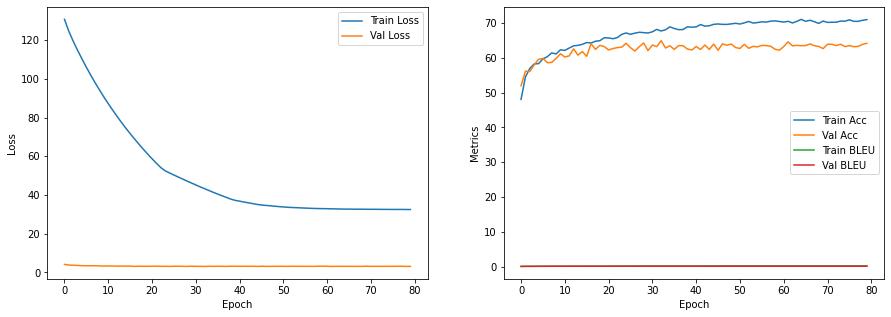

In [5]:
def train_model(encoder, decoder, train_loader, val_loader, criterion, 
                encoder_optimizer, decoder_optimizer, device, tokenizer, num_epochs=100):
    print("Starting training...")
    metrics_tracker = MetricsTracker()

    # Learning rate scheduler
    encoder_scheduler = ReduceLROnPlateau(encoder_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    decoder_scheduler = ReduceLROnPlateau(decoder_optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

        # Training phase
        encoder.train()
        decoder.train()
        total_train_loss, total_train_acc, total_train_bleu = 0, 0, 0
        train_batches = len(train_loader)

        train_progress = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=True, dynamic_ncols=True)
        for images, captions in train_progress:
            images = images.to(device)
            captions = captions.to(device).long()

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions[:, :-1])

            # Align sequence lengths
            outputs = outputs[:, :captions.size(1) - 1, :]
            loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))

            # L2 Regularization
            l2_lambda = 1e-5
            l2_norm = sum(p.pow(2.0).sum() for p in decoder.parameters())
            loss = loss + l2_lambda * l2_norm

            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1)

            encoder_optimizer.step()
            decoder_optimizer.step()

            # Calculate accuracy and BLEU
            acc = calculate_accuracy(outputs, captions[:, 1:])
            _, predictions = outputs.max(-1)
            bleu = calculate_bleu_score(predictions, captions[:, 1:], tokenizer)

            total_train_loss += loss.item()
            total_train_acc += acc
            total_train_bleu += bleu

            train_progress.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.2f}%", bleu=f"{bleu:.4f}")
        train_progress.close()

        # Validation phase
        encoder.eval()
        decoder.eval()
        total_val_loss, total_val_acc, total_val_bleu = 0, 0, 0
        val_batches = len(val_loader)

        val_progress = tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=True, dynamic_ncols=True)
        with torch.no_grad():
            for images, captions in val_progress:
                images = images.to(device)
                captions = captions.to(device).long()

                # Forward pass
                features = encoder(images)
                outputs = decoder(features, captions[:, :-1])

                # Align sequence lengths
                outputs = outputs[:, :captions.size(1) - 1, :]
                loss = criterion(outputs.reshape(-1, outputs.size(2)), captions[:, 1:].reshape(-1))

                # Calculate accuracy and BLEU
                acc = calculate_accuracy(outputs, captions[:, 1:])
                _, predictions = outputs.max(-1)
                bleu = calculate_bleu_score(predictions, captions[:, 1:], tokenizer)

                total_val_loss += loss.item()
                total_val_acc += acc
                total_val_bleu += bleu

                val_progress.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.2f}%", bleu=f"{bleu:.4f}")
        val_progress.close()

        # Calculate average metrics
        avg_train_loss = total_train_loss / train_batches
        avg_train_acc = total_train_acc / train_batches
        avg_train_bleu = total_train_bleu / train_batches
        avg_val_loss = total_val_loss / val_batches
        avg_val_acc = total_val_acc / val_batches
        avg_val_bleu = total_val_bleu / val_batches

        metrics_tracker.update(avg_train_loss, avg_train_acc, avg_train_bleu, is_train=True)
        metrics_tracker.update(avg_val_loss, avg_val_acc, avg_val_bleu, is_train=False)

        # Print epoch summary
        print(f"\nEpoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Train BLEU: {avg_train_bleu:.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}]: Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%, Val BLEU: {avg_val_bleu:.4f}")

        # Step the schedulers with the validation loss
        encoder_scheduler.step(avg_val_loss)
        decoder_scheduler.step(avg_val_loss)

    # Save final checkpoint
    final_checkpoint_path = "final_checkpoint.pth"
    torch.save({
        'epoch': num_epochs,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
    }, final_checkpoint_path)

    print(f"\nFinal model checkpoint saved: {final_checkpoint_path}")
    metrics_tracker.plot_metrics(save_path="training_validation_metrics.png")


# Call the function with the required parameters
train_model(gpt2_encoder, decoder, train_loader, val_loader, criterion, 
            encoder_optimizer, decoder_optimizer, device, tokenizer, num_epochs=num_epochs)


num_layers---------> 1
End of sequence token encountered. Stopping generation.
Generated caption: old building with a window in its front of it

Actual captions:
1. A brick building with an open window next to a few colorful bushes.
2. The stone building has an opened window on it's side.
3. A building with wide open windows and red ivy
4. A view form under a tree of a window
5. There is a small window in a stone building


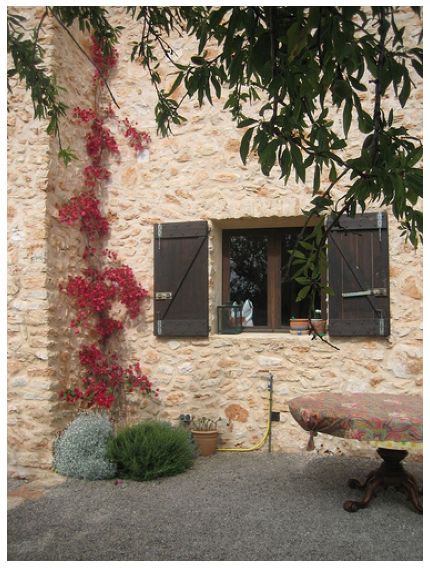

In [10]:
def generate_caption(
    encoder, 
    decoder, 
    image_path, 
    transform, 
    tokenizer, 
    device, 
    max_length=50, 
    temperature=1.0, 
    top_k=5, 
    debug=False
):
    """
    Generate a caption for an image using the encoder and decoder.

    Args:
        encoder (nn.Module): Image encoder model.
        decoder (nn.Module): Caption decoder model.
        image_path (str): Path to the image.
        transform (transforms.Compose): Transformations for the image.
        tokenizer (Tokenizer): Tokenizer to decode token IDs into text.
        device (torch.device): Device for computation.
        max_length (int): Maximum length of the generated caption.
        temperature (float): Sampling temperature to control randomness.
        top_k (int): Number of top tokens to sample from.
        debug (bool): Whether to print debug information.

    Returns:
        str: Generated caption.
    """
    encoder.eval()
    decoder.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Extract image features
    with torch.no_grad():
        features = encoder(image)

    # Initialize decoding
    input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)  # Start with <BOS>
    captions = []

    for step in range(max_length):
        with torch.no_grad():
            # Forward pass through the decoder
            outputs = decoder(features, input_ids)
            logits = outputs[:, -1, :]  # Focus on the last time step
            
            # Apply temperature and compute probabilities
            probs = torch.softmax(logits / temperature, dim=-1)
            
            # Top-k sampling
            if top_k > 0:
                top_probs, top_indices = torch.topk(probs, k=top_k)
                top_probs /= top_probs.sum()  # Normalize top-k probabilities
                predicted_token_id = torch.multinomial(top_probs, 1).item()
                predicted_token = top_indices.squeeze(0)[predicted_token_id].item()
            else:
                predicted_token = torch.multinomial(probs, 1).item()  # Sample from all probabilities

            # Debugging information
            if debug:
                print(f"Step {step + 1}:")
                print(f"Logits shape: {logits.shape}")
                print(f"Top predictions: {top_indices.squeeze(0).tolist()}")
                print(f"Top probabilities: {top_probs.squeeze(0).tolist()}")
                print(f"Predicted token ID: {predicted_token}, Decoded: {tokenizer.decode([predicted_token])}")

        # Handle invalid predictions
        if predicted_token is None or predicted_token < 0 or predicted_token >= len(tokenizer):
#             print(f"Warning: Invalid token ID {predicted_token}. Stopping generation.")
            break

        # Stop if <EOS> token is predicted
        if predicted_token == tokenizer.eos_token_id:
            if len(captions) == 0:
#                 print("Warning: <EOS> predicted at the start. Ignoring and continuing.")
                continue
            else:
                print("End of sequence token encountered. Stopping generation.")
                break

        # Append the token to the captions list
        captions.append(predicted_token)

        # Update the input sequence
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_token]], device=device)], dim=1)

    # Decode token IDs into text
    generated_caption = tokenizer.decode(captions, skip_special_tokens=True).strip()
    
    # Return the generated caption
    return generated_caption









def test_model(checkpoint_path, test_image_path, embed_size=256, hidden_size=512, num_layers=1, gpt2_model_name="gpt2"):
    
    print("num_layers--------->", num_layers)
    
    # Initialize tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'}) 
    
    # Initialize the transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Load models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize encoder
    encoder = GPT2Encoder(embed_size).to(device)
    
    # Initialize decoder with correct vocabulary size
    decoder = DecoderRNN(embed_size, hidden_size, len(tokenizer), num_layers=num_layers).to(device)
    decoder.embed = nn.Embedding(len(tokenizer), embed_size).to(device)
    
    # Load the checkpoint
    checkpoint = torch.load("final_checkpoint.pth", map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'], strict=False)
    decoder.load_state_dict(checkpoint['decoder_state_dict'], strict=False)
    
#     print(f"Decoder embedding weights: {decoder.embed.weight.mean()}, {decoder.embed.weight.std()}")

    
#     print("BOS Token:", tokenizer.bos_token_id)
#     print("EOS Token:", tokenizer.eos_token_id)
#     print("PAD Token:", tokenizer.pad_token_id)
    
#     print("Encoder state dict keys:", list(encoder.state_dict().keys())[:5])
#     print("Decoder state dict keys:", list(decoder.state_dict().keys())[:5])


    
    # Generate caption
#     caption = generate_caption(encoder, decoder, test_image_path, transform, tokenizer, device)
    caption = generate_caption(
        encoder=gpt2_encoder, 
        decoder=decoder, 
        image_path=test_image_path, 
        transform=transform, 
        tokenizer=tokenizer, 
        device=device, 
        max_length=50, 
        temperature=0.8, 
        top_k=10, 
        debug=False  # Turn debugging on or off
    )

    print(f"Generated caption: {caption}")
    return caption



def test_random_image(dataset):
    # Get a random image from our dataset
    random_idx = random.randint(0, len(dataset.img_ids) - 1)
    img_id = dataset.img_ids[random_idx]
    img_info = dataset.coco.loadImgs(img_id)[0]
    img_path = os.path.join(dataset.root_dir, img_info['file_name'])
    
    # Get actual captions for comparison
    ann_ids = dataset.coco.getAnnIds(imgIds=img_id)
    anns = dataset.coco.loadAnns(ann_ids)
    actual_captions = [ann['caption'] for ann in anns]
    
    # Test the model
    checkpoint_filename = "final_checkpoint.pth"
    generated_caption = test_model(checkpoint_filename, img_path, num_layers=num_layers)
    
    # Print actual captions for comparison
    print("\nActual captions:")
    for i, caption in enumerate(actual_captions, 1):
        print(f"{i}. {caption}")
    
    # Display the image with larger size
    plt.figure(figsize=(10, 8))  # Increased figure size
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()  # Ensures the image fills the figure space
    plt.show()

# To run the test, you need to pass the dataset:
test_random_image(val_dataset.dataset)  # where dataset is your ImageCaptioningDataset instance

num_layers---------> 1
End of sequence token encountered. Stopping generation.
Generated caption: bus parked at a bus stop on the sidewalk.

Actual captions:
1. The passenger bus is stopping alongside of the street.
2. A commuter bus parked in front of  bus stop.
3. A bus next to a bus stop sign waiting for passengers. 
4. A bus pausing at a bus stop for passengers. 
5. a bus sitting at a bus stop in the street.


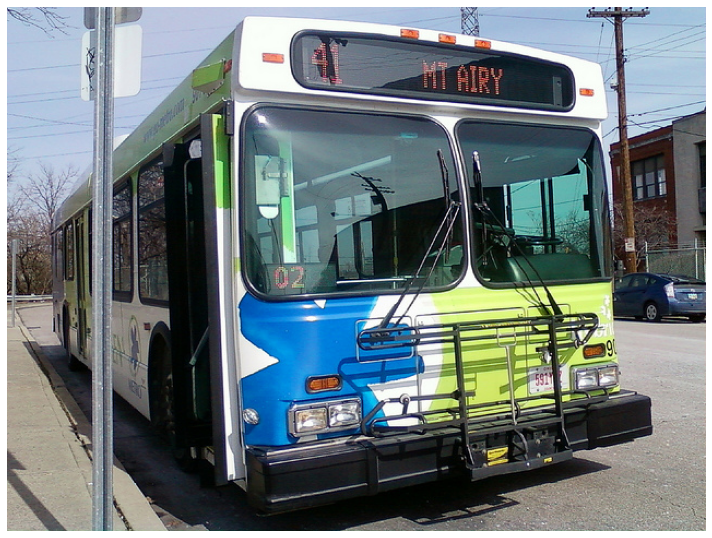

In [7]:
test_random_image(val_dataset.dataset)